# Model 3b:

Batched Draupnir Model by padding


Model details:

|Flavor|Included or Not|
|:---------:|:-----:|
|Unaligned Sequences|Padding|
|Latent Tree| |
|Batched Input|×|




In [ ]:
leaf_seq_path = "/content/realign_MSA.fas"
ancestor_path = "/content/_pep_Unaligned_Internal_Nodes.FASTA"
tree_path = "/content/_True_Rooted_tree_node_labels.tre"

In [ ]:
! pip install pyro-ppl
! pip install Biopython

     |████████████████████████████████| 718 kB 33.9 MB/s 
     |████████████████████████████████| 2.3 MB 30.6 MB/s 


In [ ]:
import pyro
import torch
from helper import *
from PyroModel import *
from JAXFunctions import *
from Error_measure import *
from torch.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt
from pyro.infer import SVI, Trace_ELBO
from sklearn.manifold import TSNE
from scipy.stats import spearmanr, pearsonr
import os
import math

from ASR import ASR

In [ ]:
batch_size = 128

In [ ]:
AA_dict, back_AA_dict = get_AA_dict(n_c=24)
S, S_names, S_lengths, S_char = load_Unaligned_Data(leaf_seq_path, "cuda", AA_dict)

_, Anc_names, Anc_lengths, Anc_char = load_Unaligned_Data(ancestor_path, "cuda", AA_dict)
Anc_names[Anc_names.index("Node1 The root")] = "Node1"

In [ ]:
def get_true_tree_distances_including_ancestors(true_tree_path, S_names, ancestor_names):
    """
    Only work for simulation data
    Since the names of simulated ancestors are just numbers, Biopython will interpret them as "confidence" by default
    And there is no name/confidence for root

    """
    t = Phylo.read(true_tree_path, "newick")
    nodes = t.get_terminals() + t.get_nonterminals()
    mat = np.zeros([len(nodes), len(nodes)])
    names = S_names + ancestor_names

    for x, y in itertools.combinations(nodes, 2):
        v = t.distance(x, y)
        x_name = "Node" + str(x.confidence) if x.confidence is not None else "Node1" if x.name is None else x.name
        y_name = "Node" + str(y.confidence) if y.confidence is not None else "Node1" if y.name is None else y.name
        idx, idy = names.index(x_name), names.index(y_name)
        mat[idx][idy] = v
        mat[idy][idx] = v
    return mat

In [ ]:
# true_tree_distances_including_ancestors = get_true_tree_distances_including_ancestors(tree_path, S_names, Anc_names)
# true_tree_distances = true_tree_distances_including_ancestors[:len(S_names), :len(S_names)]

import pickle

# with open("matrix.txt", "wb") as f:
#     pickle.dump(true_tree_distances_including_ancestors, f)
with open("matrix.txt", "rb") as f:
    true_tree_distances_including_ancestors = pickle.load(f)
true_tree_distances = true_tree_distances_including_ancestors[:len(S_names), :len(S_names)]

In [ ]:
true_tree_distances_including_ancestors.shape, true_tree_distances.shape

((2047, 2047), (1024, 1024))

In [ ]:
pyro.clear_param_store()
vae = VAE(50, 24, S.shape[1])

In [ ]:
def per_param_callable(module_name, param_name):
    return {"lr": 0.001, "clip_norm": 10}
optimizer = pyro.optim.ClippedAdam(per_param_callable)
svi = SVI(vae.standard_asr_batched_model, vae.standard_asr_batched_guide, optimizer, loss=Trace_ELBO(num_particles=1))

In [ ]:
ELBOs = []

Rec_Acc = []
Rec_Acc_remove_gap = []

In [ ]:
for b in tqdm(range(401)):
    indices = np.random.choice(S.shape[0], S.shape[0], False)
    elbos = []
    for batch in range(S.shape[0] // batch_size - 1):
      batch_idx = indices[batch * batch_size: batch * batch_size + batch_size]
      back_idx = indices[S.shape[0] // batch_size * batch_size - batch_size:]
      all_idx = np.concatenate([back_idx, batch_idx])
      elbo = svi.step(aligned_S=S[batch_idx], 
               aligned_S_back=S[back_idx],
               batch_distance=torch.from_numpy(true_tree_distances[all_idx][:, all_idx]).float().to(vae.device), 
               num_batch=S.shape[0] // batch_size - 1)
      elbos.append(elbo)
    ELBOs.append(sum(elbos) / len(elbos))

  
    if b % 10 == 0:
        with torch.no_grad():
            # Rec ACC
            S_onehot = torch.zeros_like(S[:, :, None]).expand([-1, -1, 24]).clone().scatter_(-1, S[:, :, None], 1)
            S_onehot = S_onehot[:, :, :].float().cuda()
           
            Z_loc = vae.encoder(S_onehot, None)
            re_MSA = vae.decoder.forward(None, Z_loc, False)

            Rec_Acc_remove_gap.append(np.mean(reconstruction_accuracy(re_MSA, S_onehot, gap_index=23, remove_gap=True)))
            Rec_Acc.append(np.mean(reconstruction_accuracy(re_MSA, S_onehot, gap_index=23, remove_gap=False)))
          
# Distances Correlation
latent_distance = 1 - torch.sum(Z_loc[None, :, :] * Z_loc[:, None, :], dim=-1) / torch.norm(Z_loc, p=2, dim=-1)[None, :] / torch.norm(Z_loc, p=2, dim=-1)[:, None]
latent_distance = torch.norm(Z_loc[None, :, :] - Z_loc[:, None, :], dim=-1)
latent_distance_upper = latent_distance[torch.triu_indices(S.shape[0], S.shape[0], 1)[0], torch.triu_indices(S.shape[0], S.shape[0], 1)[1]]
real_distance_upper = true_tree_distances[torch.triu_indices(S.shape[0], S.shape[0], 1)[0], torch.triu_indices(S.shape[0], S.shape[0], 1)[1]]
Spearmans = spearmanr(latent_distance_upper.cpu(), real_distance_upper)[0]
Pearsonss = pearsonr(latent_distance_upper.cpu(), real_distance_upper)[0]

# ASR ACC
sigma_f = pyro.param("sigma_f_loc")
sigma_n = pyro.param("sigma_n_loc")
lambd = pyro.param("lambd_loc")

cov = torch.from_numpy(true_tree_distances_including_ancestors).to(vae.device).float()[np.newaxis, :, :].expand([vae.n_z, true_tree_distances_including_ancestors.shape[0], true_tree_distances_including_ancestors.shape[0]]) / lambd[:, np.newaxis, np.newaxis]
cov = (torch.exp(-cov) * sigma_f[:, np.newaxis, np.newaxis] ** 2 + torch.eye(cov.shape[1], device=vae.device)[np.newaxis, :, :] * sigma_n[:, np.newaxis, np.newaxis] ** 2)
cov_tips = cov[:, :len(S_names), :len(S_names)]
cov_anc = cov[:, len(S_names):, len(S_names):]
con_tips_anc = cov[:, len(S_names):, :len(S_names)]

rec_anc = ASR(Z_loc, cov_tips, cov_anc, con_tips_anc, decoder=lambda x: vae.decoder(None, x, False))
rec_anc = tensor2char(rec_anc, back_AA_dict)
# accs = asr_accuracy(Anc_char, rec_anc)
# ASR_Acc.append(np.mean(accs))
# ASR_Acc_std.append(np.std(accs))
# ASR_Acc_max.append(np.max(accs))
# ASR_Acc_min.append(np.min(accs))

# LCA ASR ACC
t = Phylo.read(tree_path, "newick")
tips = t.get_terminals()
ground = []
predicts = []
for i in range(len(tips)):
    for j in range(i+1, len(tips)):
        lca = t.common_ancestor(tips[i], tips[j])
        lca_name = "Node" + str(lca.confidence) if lca.confidence is not None else "Node1" 
        lca_index = Anc_names.index(lca_name)
        ground.append(Anc_char[lca_index])
        predicts.append(rec_anc[lca_index])
accs = asr_accuracy(ground, predicts)
LCA_ASR_Acc = np.mean(accs)
LCA_ASR_Acc_std = np.std(accs)
LCA_ASR_Acc_max = np.max(accs)
LCA_ASR_Acc_min = np.min(accs)

  0%|          | 0/401 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/distributions/gamma.py:71: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /root/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/cuda/jit_utils.cpp:860.)
  self.rate * value - torch.lgamma(self.concentration))
100%|██████████| 401/401 [25:59<00:00,  3.89s/it]


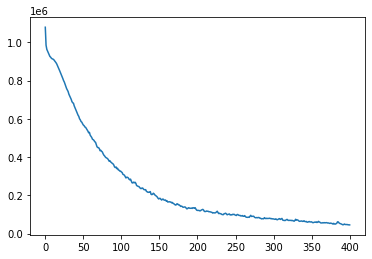

In [ ]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(ELBOs)

In [ ]:
print(Spearmans, Pearsonss)

0.4200116433501106 0.555179245564891


In [ ]:
LCA_ASR_Acc, LCA_ASR_Acc_std, LCA_ASR_Acc_max, LCA_ASR_Acc_min

(0.3773416875481014,
 0.05894505846036393,
 0.9902597402597403,
 0.32344213649851633)